In [21]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost

In [22]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [23]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,August-24-2021,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,August-24-2021,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,August-23-2021,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,August-23-2021,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,August-23-2021,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [24]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [25]:
df.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,2021-08-24,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,2021-08-24,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,2021-08-23,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,2021-08-23,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,2021-08-23,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [27]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,stories,schools,days_on_mkt,hoa
count,1.011000e+03,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,1.126206e+06,3.633037,2.544510,2081.720079,10828.724036,1960.297725,0.134520,0.140455,1.178042,5.738731,44.678536,2.430267
std,5.022851e+05,0.844819,0.924634,886.574023,15533.545033,11.616964,0.341379,0.347630,0.387876,0.674897,24.281487,24.731666
min,4.000000e+05,1.000000,1.000000,552.000000,2000.000000,1920.000000,0.000000,0.000000,1.000000,4.200000,1.000000,0.000000
25%,8.400000e+05,3.000000,2.000000,1471.000000,7083.000000,1954.000000,0.000000,0.000000,1.000000,5.200000,25.000000,0.000000
50%,9.650000e+05,4.000000,2.000000,1873.000000,8217.000000,1958.000000,0.000000,0.000000,1.000000,5.666667,44.000000,0.000000
75%,1.260000e+06,4.000000,3.000000,2447.000000,11761.000000,1964.000000,0.000000,0.000000,1.000000,6.166667,64.000000,0.000000
max,5.500000e+06,8.000000,8.000000,8189.000000,475675.000000,2021.000000,1.000000,1.000000,3.000000,7.666667,90.000000,585.000000


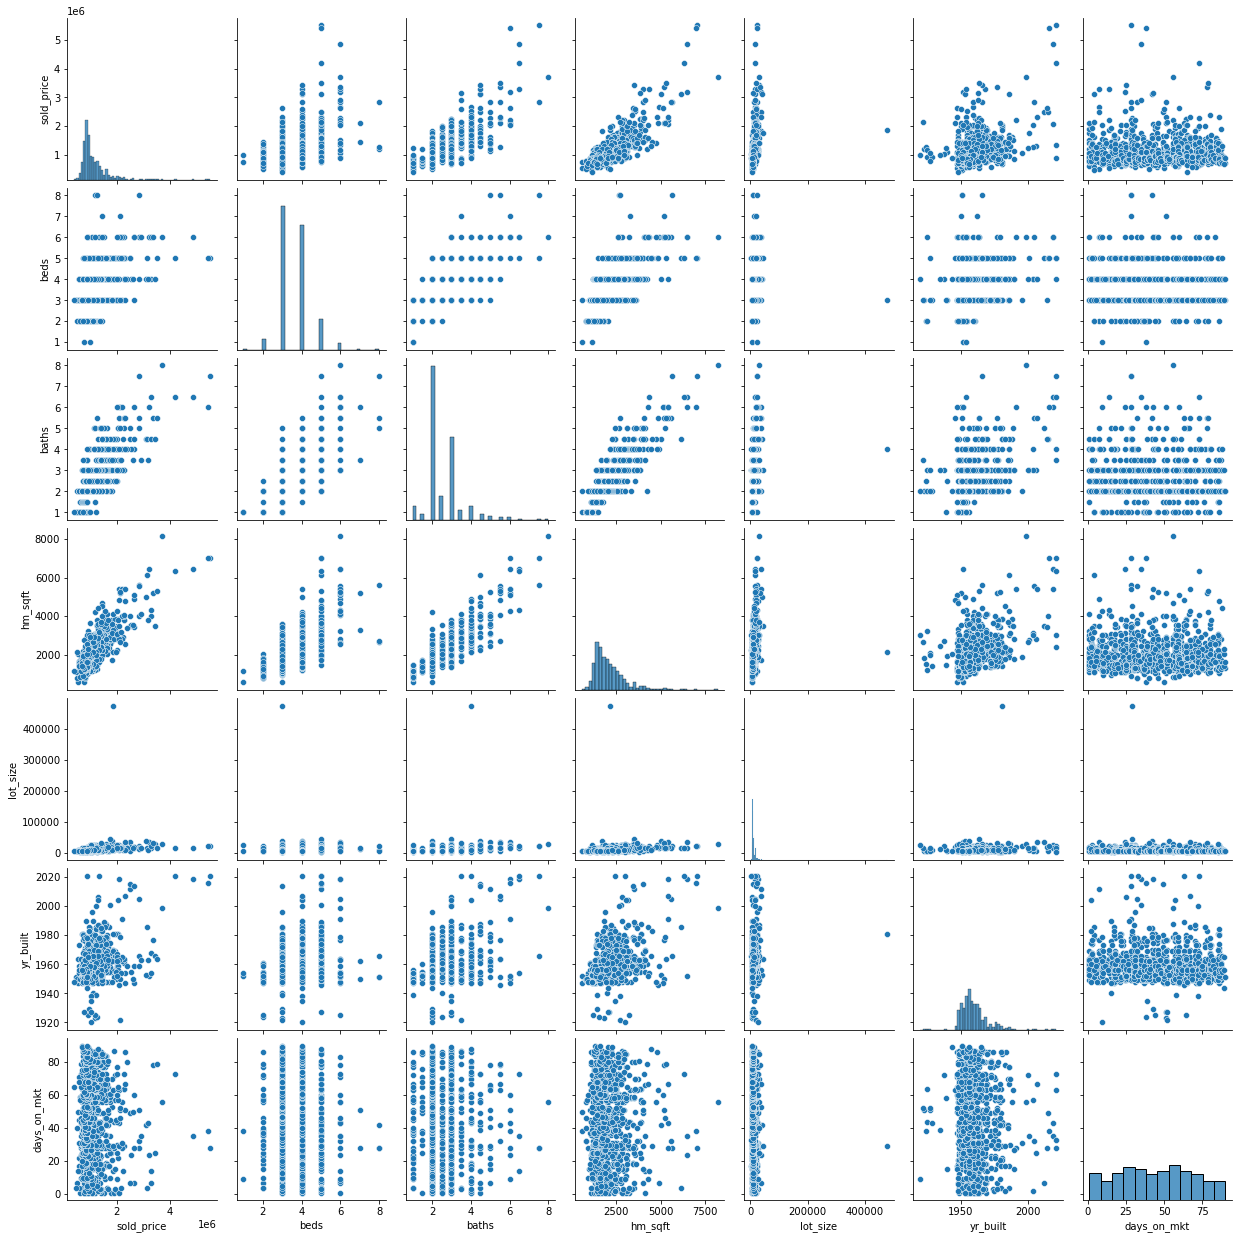

In [28]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [29]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


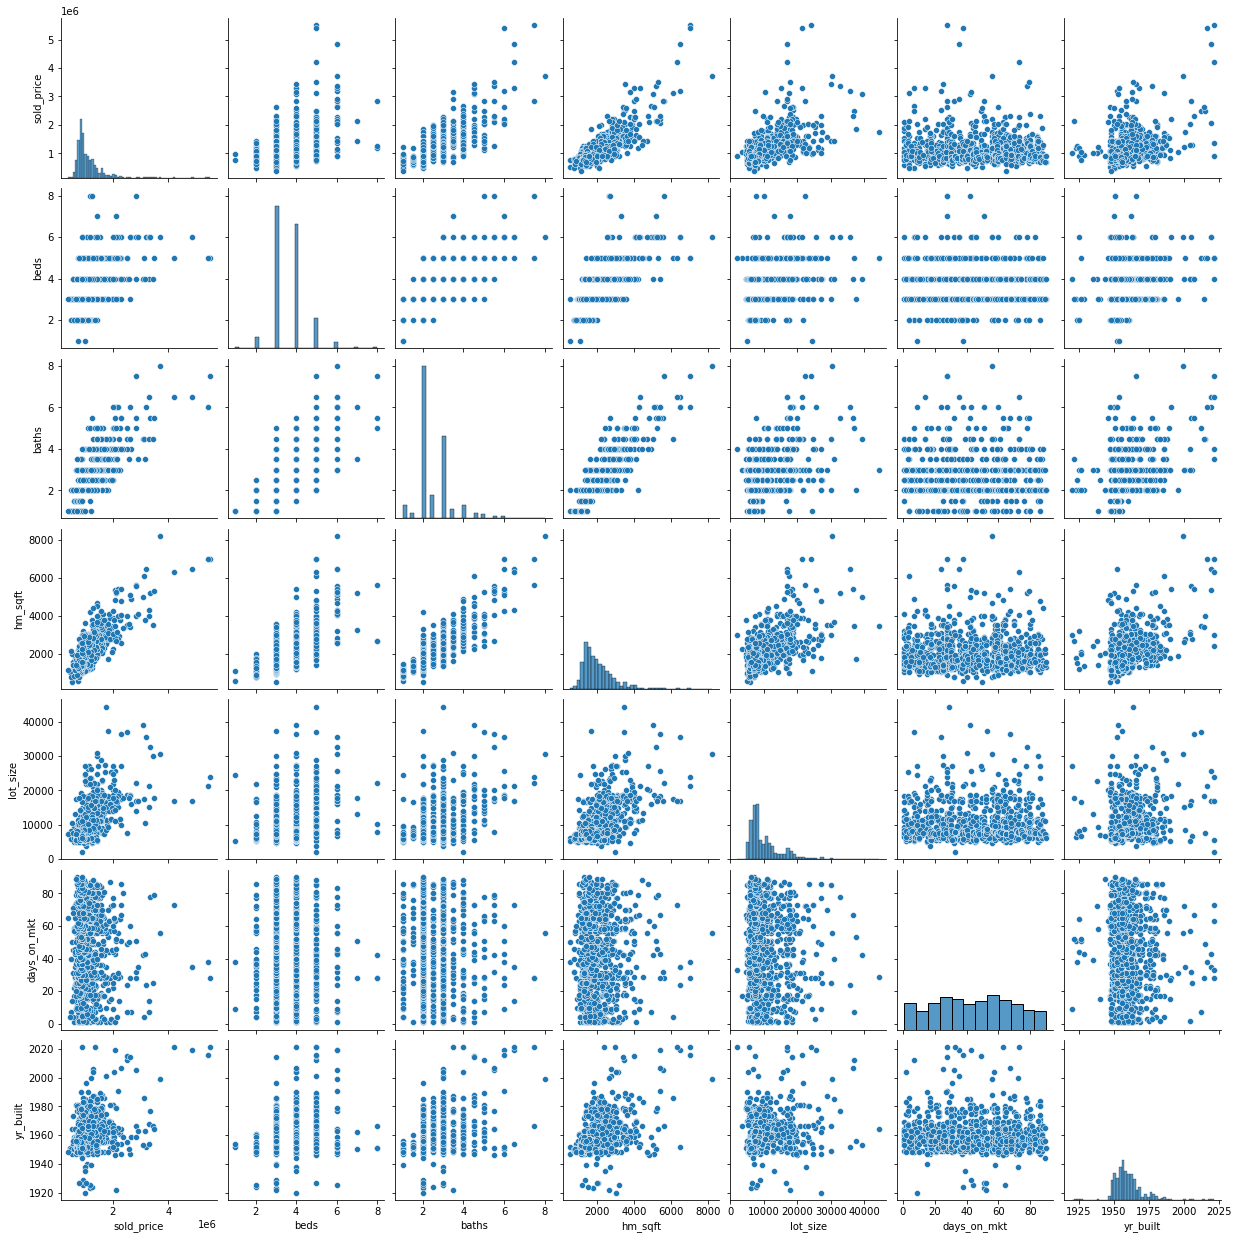

In [30]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [31]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,days_on_mkt
sold_price,1.000000,0.468586,0.747992,0.836873,0.616309,0.405557,-0.015035
beds,0.468586,1.000000,0.677780,0.673701,0.353676,0.330157,-0.003969
baths,0.747992,0.677780,1.000000,0.853740,0.506800,0.425517,-0.003983
hm_sqft,0.836873,0.673701,0.853740,1.000000,0.611860,0.482993,-0.012386
lot_size,0.616309,0.353676,0.506800,0.611860,1.000000,0.235796,-0.011387
yr_built,0.405557,0.330157,0.425517,0.482993,0.235796,1.000000,-0.031676
days_on_mkt,-0.015035,-0.003969,-0.003983,-0.012386,-0.011387,-0.031676,1.000000


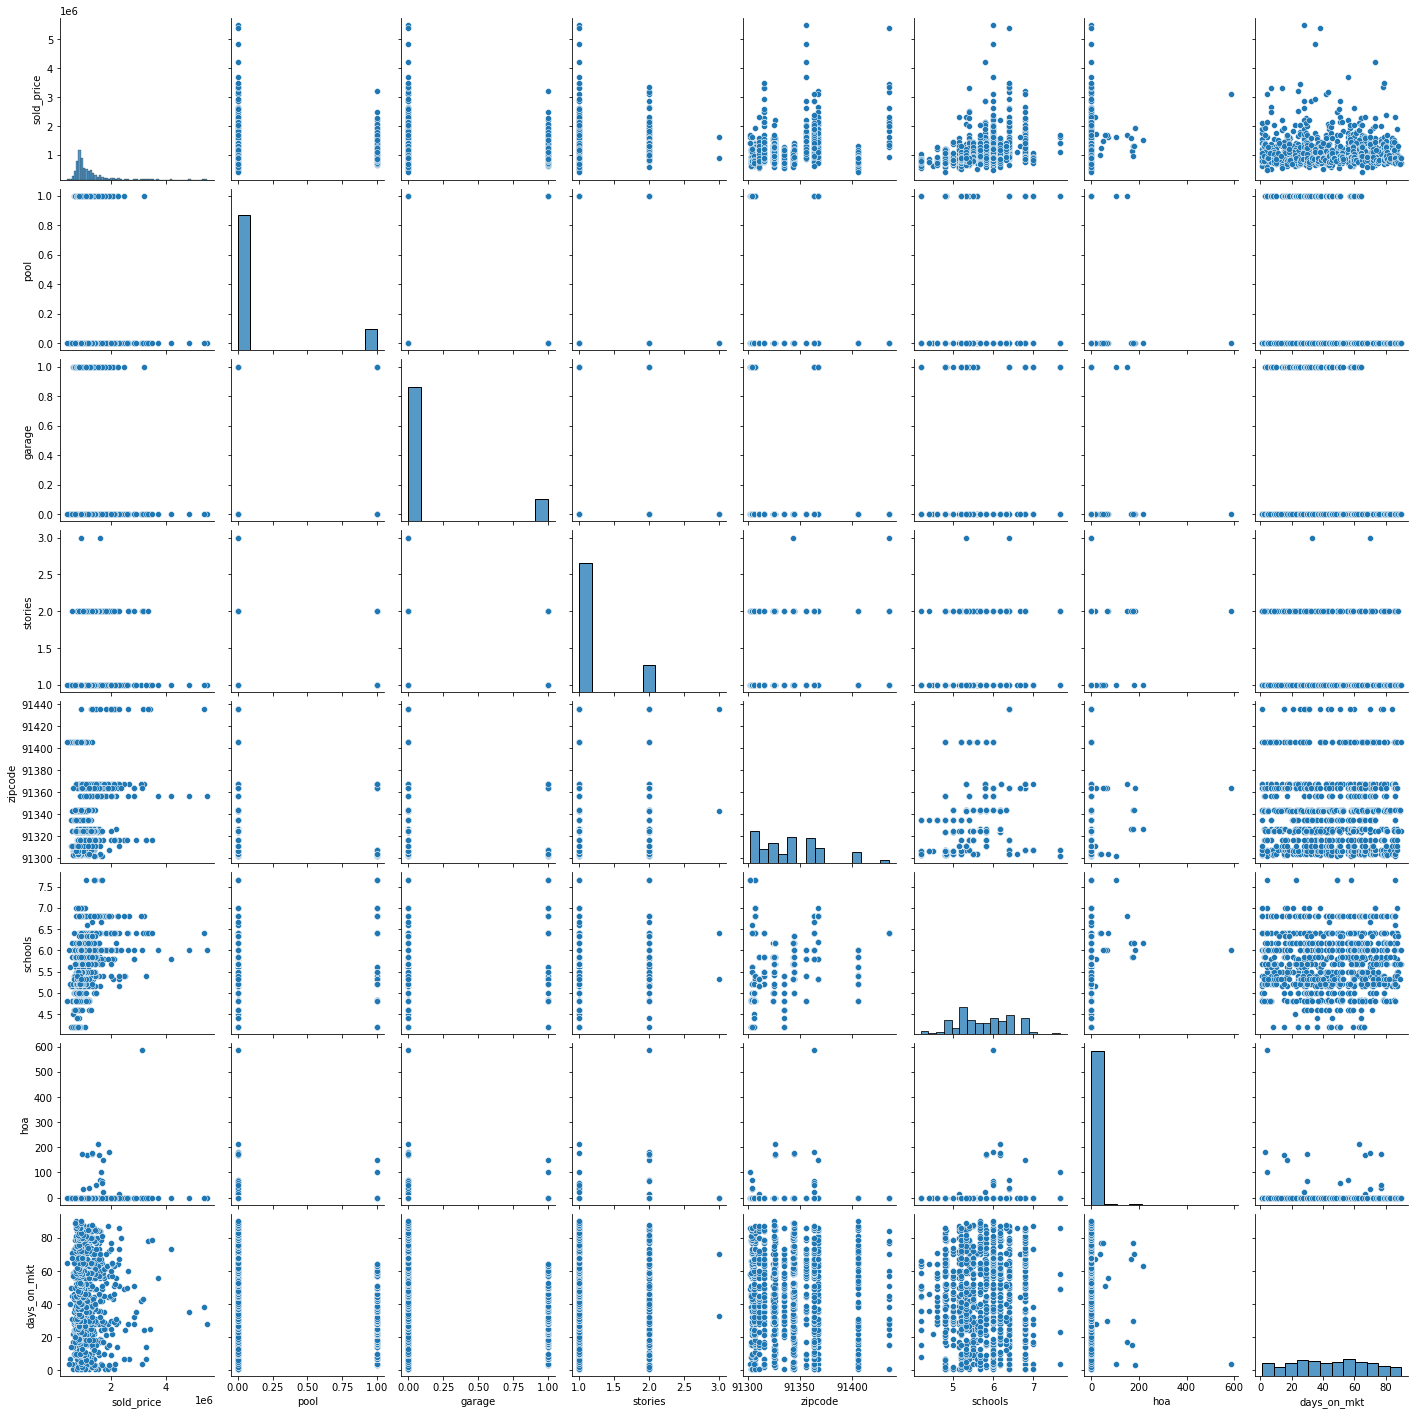

In [32]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [33]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

,sold_price,pool,garage,stories,zipcode,schools,hoa,days_on_mkt
sold_price,1.000000,0.028298,0.025144,0.187080,0.219329,0.356463,0.143552,-0.015035
pool,0.028298,1.000000,0.950247,0.074175,-0.100235,0.268048,-0.009247,-0.219170
garage,0.025144,0.950247,1.000000,0.057655,-0.096038,0.280840,-0.010762,-0.225222
stories,0.187080,0.074175,0.057655,1.000000,-0.028739,0.177494,0.136809,-0.051873
zipcode,0.219329,-0.100235,-0.096038,-0.028739,1.000000,0.267983,0.006319,-0.012574
schools,0.356463,0.268048,0.280840,0.177494,0.267983,1.000000,0.061756,-0.026134
hoa,0.143552,-0.009247,-0.010762,0.136809,0.006319,0.061756,1.000000,-0.042238
days_on_mkt,-0.015035,-0.219170,-0.225222,-0.051873,-0.012574,-0.026134,-0.042238,1.000000


#### Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

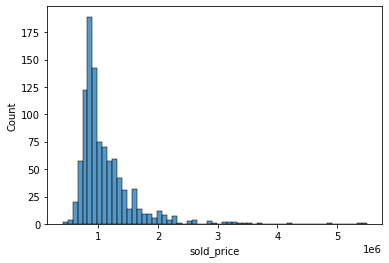

In [34]:
sns.histplot(data=df['sold_price']);

#### Perhaps log transforming the target can lead to a better model

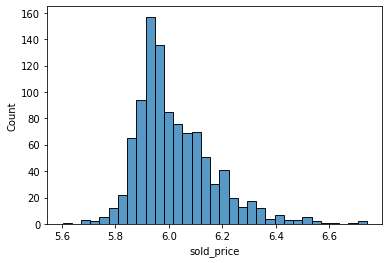

In [35]:
sns.histplot(data=np.log10(df['sold_price']));

# 2) Feature Engineering (part 1)

### Given VIFs seen previously with zipcode 1-hots, let's try just dropping 'zipcode' instead

In [36]:
df_data = df.drop(columns=['zipcode', 'sold_date', 'address', 'days_on_mkt', 'url', 'lat', 'lon'])

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [37]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [38]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,one_story,schools,hoa
0,970000,4,3.0,1933,6999,1960,1,1,1,6.4,0
1,900000,3,2.0,1519,11761,1974,1,1,1,6.4,0
2,830000,3,2.0,1595,10560,1960,1,1,1,4.8,0
3,820000,3,2.5,1364,7253,1959,0,0,1,7.0,0
4,940553,4,2.5,2018,9347,1960,1,1,1,6.8,0


In [39]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [41]:
def diagnostic_plots(x, y, y_pred):    
    
#     print('RMSE: {}'.format(round(mean_squared_error(y, y_pred, squared=False), 3)))
#     print('MAE: {}'.format(round(mean_absolute_error(y, y_pred), 3)))
    
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.title("Predicted vs. Actual Sale Price")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [42]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [43]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

In [44]:
X = df_data.drop(columns='sold_price')
y = df_data['sold_price']

In [45]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [46]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.755, 0.718, 0.727, 0.759, 0.768]
Mean CV R-squared: 0.745 +/- 0.019

Adjusted CV R-squareds: [0.752, 0.714, 0.724, 0.756, 0.765]
Mean Adjusted CV R-squared: 0.742 +/- 0.02

CV MAEs: [179356, 155190, 161234, 165099, 160388]
Mean CV MAE: 164253 +/- 8185


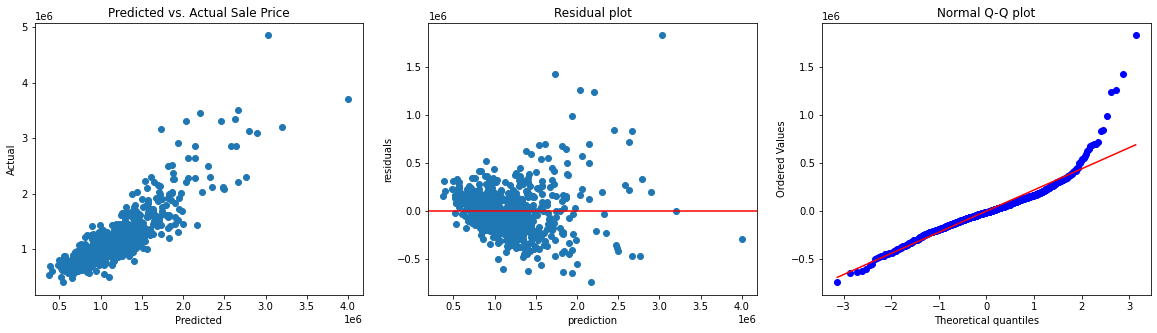

In [47]:
model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [48]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 06 Sep 2021   Prob (F-statistic):          6.81e-244
Time:                        19:48:00   Log-Likelihood:                -11123.
No. Observations:                 808   AIC:                         2.227e+04
Df Residuals:                     797   BIC:                         2.232e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.927e+05   1.65e+06      0.117      0.907   -3.05e+06    3.44e+06
beds       -7.822e+04   1.42e+04     -5.508      0.000   -1.06e+05   -5.03e+04
baths       1.248e+05   1.77e+04      7.058      0.000    9.01e+04    1.59e+05
hm_sqft      333.1122     20.943     15.906      0.000     292.002     374.222
lot_size      15.1609      2.045      7.415      0.000      11.147      19.174
yr_built    -379.9591    848.560     -0.448      0.654   -2045.636    1285.718
pool       -5.293e+04   7.99e+04     -0.662      0.508    -2.1e+05    1.04e+05
garage      3.665e+04   7.84e+04      0.467      0.640   -1.17e+05    1.91e+05
one_story    1.48e+05   2.41e+04      6.133      0.000    1.01e+05    1.95e+05
schools     1.165e+05   1.34e+04      8.670      0.000    9.01e+04    1.43e+05
hoa          317.8393    307.319      1.034      0.301    -285.410     921.089
==============================================================================
Omnibus:                      322.164   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3094.275
Skew:                           1.531   Prob(JB):                         0.00
Kurtosis:                      12.085   Cond. No.                     2.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

413    0.588325
468    0.479919
692    0.070039
695    0.063341
700    0.052059
Name: cooks_d, dtype: float64

##### Largest Cook's distances are all for sale prices > 3e6

In [50]:
print(y_cv.loc[468])
print(y_cv.loc[413])
print(y_cv.loc[695])
print(y_cv.loc[692])

4850000
3125000
3162000
3445000


In [51]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [52]:
df_data['sold_price'].describe()

count    1.010000e+03
mean     1.125490e+06
std      5.020166e+05
min      4.000000e+05
25%      8.400000e+05
50%      9.650000e+05
75%      1.260000e+06
max      5.500000e+06
Name: sold_price, dtype: float64

In [53]:
df_data[df_data['sold_price'] <= 3e6]['sold_price'].describe()

count    9.960000e+02
mean     1.087947e+06
std      3.799263e+05
min      4.000000e+05
25%      8.387500e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

#### While we're here, what about colinearity (VIF)?

In [54]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.141562783366988),
 ('baths', 3.9174676049604136),
 ('hm_sqft', 5.132059101281228),
 ('lot_size', 1.7044380727981554),
 ('yr_built', 1.4157432405465602),
 ('pool', 11.465160847757023),
 ('garage', 11.451602909943244),
 ('one_story', 1.27530444738745),
 ('schools', 1.229190639326232),
 ('hoa', 1.077798769746699)]

In [55]:
df_data[['pool', 'garage']].corr()

,pool,garage
pool,1.000000,0.950247
garage,0.950247,1.000000


In [56]:
df_data[['pool', 'garage']].value_counts()

pool  garage
0     0         865
1     1         133
0     1           9
1     0           3
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [57]:
df_data = df_data.drop(columns='pool')

In [58]:
df_data.columns

Index(['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built',
       'garage', 'one_story', 'schools', 'hoa'],
      dtype='object')

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes)

In [59]:
X = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
y = df_data[df_data['sold_price'] <= 3e6]['sold_price']

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.782, 0.746, 0.718, 0.602, 0.683]
Mean CV R-squared: 0.706 +/- 0.061

Adjusted CV R-squareds: [0.78, 0.743, 0.715, 0.597, 0.679]
Mean Adjusted CV R-squared: 0.703 +/- 0.062

CV MAEs: [156828, 144043, 151955, 143651, 142038]
Mean CV MAE: 147703 +/- 5714


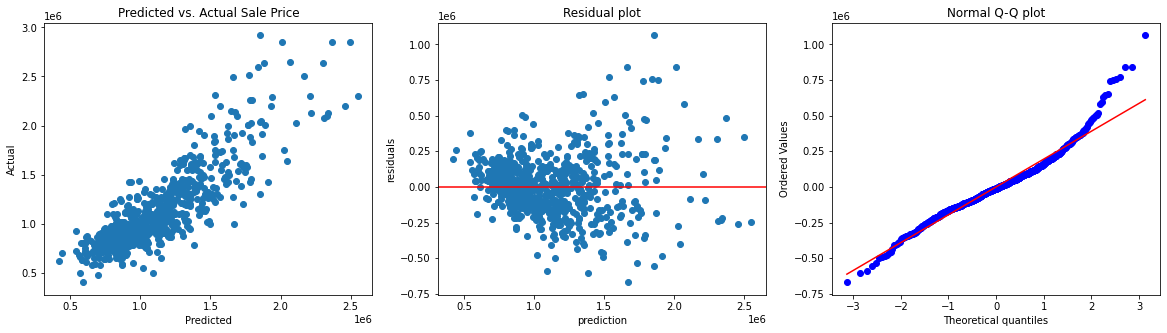

In [61]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

### Model 2: Try adding some further features

#### 'beds', 'baths', 'hm_sqft', 'schools' all show signs of a possible 2nd-order relationship w/ 'sold_price'

In [62]:
df_data['beds_SQ'] = df_data['beds'] * df_data['beds']
df_data['baths_SQ'] = df_data['baths'] * df_data['baths']
df_data['hm_sqft_SQ'] = df_data['hm_sqft'] * df_data['hm_sqft']
df_data['lot_size_SQ'] = df_data['lot_size'] * df_data['lot_size']
df_data['schools_SQ'] = df_data['schools'] * df_data['schools']
df_data['yr_built_SQ'] = df_data['yr_built'] * df_data['yr_built']

In [63]:
X2 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [64]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.795, 0.754, 0.703, 0.616, 0.665]
Mean CV R-squared: 0.707 +/- 0.063

Adjusted CV R-squareds: [0.791, 0.749, 0.697, 0.609, 0.659]
Mean Adjusted CV R-squared: 0.701 +/- 0.064

CV MAEs: [152474, 140288, 152758, 138813, 144299]
Mean CV MAE: 145726 +/- 5906


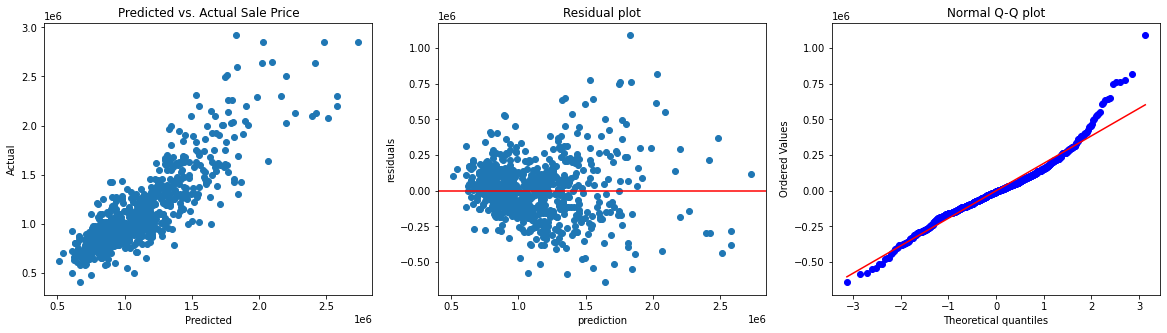

In [65]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, y2_cv, y2_pred)

In [66]:
list(zip(X2_cv.columns, model_2.coef_))

[('beds', -39771.092881752345),
 ('baths', 7955.300242560401),
 ('hm_sqft', 268.1014270681305),
 ('lot_size', 25.347975104195655),
 ('yr_built', -206111.71750136992),
 ('garage', -28216.59660492808),
 ('one_story', 93035.39742215816),
 ('schools', -315359.3244571276),
 ('hoa', -89.08880336793037),
 ('beds_SQ', -2125.9795468968637),
 ('baths_SQ', 15933.63545702494),
 ('hm_sqft_SQ', 0.00170948889376632),
 ('lot_size_SQ', -0.0003039405901290593),
 ('schools_SQ', 37980.215231593764),
 ('yr_built_SQ', 52.09234296108812)]

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [67]:
X3 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [68]:
alphas = 10**np.linspace(-4, 4, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 1867.55


In [69]:
model_3 = Lasso(alpha=1867.55, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.787, 0.747, 0.715, 0.613, 0.693]
Mean CV R-squared: 0.711 +/- 0.058

Adjusted CV R-squareds: [0.783, 0.742, 0.71, 0.606, 0.687]
Mean Adjusted CV R-squared: 0.706 +/- 0.059

CV MAEs: [153871, 142439, 150966, 140109, 138421]
Mean CV MAE: 145161 +/- 6131


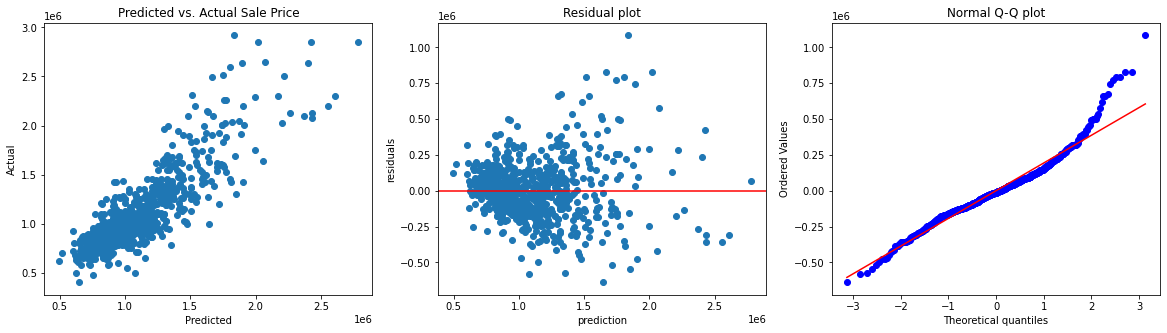

In [70]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

#### On a Mean MAE basis, this is on par w/ Model 2 (even slightly better)

In [202]:
list(zip(X3_cv.columns, model_3.coef_))

[('beds', 54257.890408783765),
 ('baths', 23628.15190086098),
 ('hm_sqft', 107536.52948205096),
 ('lot_size', 172939.71517022335),
 ('yr_built', 6501.568659125554),
 ('garage', -1171.4054375475105),
 ('one_story', 25279.686936500653),
 ('schools', -167528.7401235095),
 ('hoa', 1379.421498146657),
 ('zipcode_91303', -30557.074671948238),
 ('zipcode_91304', -73196.4205342834),
 ('zipcode_91306', -59319.55969014216),
 ('zipcode_91307', -82501.1946301835),
 ('zipcode_91311', -61721.47815926746),
 ('zipcode_91316', 26351.420199597265),
 ('zipcode_91324', -37429.32062007812),
 ('zipcode_91325', -66791.62296783968),
 ('zipcode_91326', -66965.30499482802),
 ('zipcode_91335', -45317.80841455099),
 ('zipcode_91343', -78572.33006266195),
 ('zipcode_91344', -95412.89099969504),
 ('zipcode_91356', -3069.8129804825353),
 ('zipcode_91364', -42383.29310819248),
 ('zipcode_91367', -46862.15026712736),
 ('zipcode_91406', -61118.12953148708),
 ('zipcode_91436', 33171.329268443),
 ('beds_SQ', -66422.92424

#### Nothing got driven to 0

### Model 4 - "Lazy" Ridge Regression

In [71]:
X4 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [72]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 30.03


In [74]:
model_4 = Ridge(alpha=30.03, max_iter=500000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)

CV R-squareds: [0.792, 0.75, 0.707, 0.61, 0.674]
Mean CV R-squared: 0.707 +/- 0.063

Adjusted CV R-squareds: [0.788, 0.745, 0.701, 0.602, 0.668]
Mean Adjusted CV R-squared: 0.701 +/- 0.064

CV MAEs: [153181, 141328, 152171, 139463, 143093]
Mean CV MAE: 145847 +/- 5702


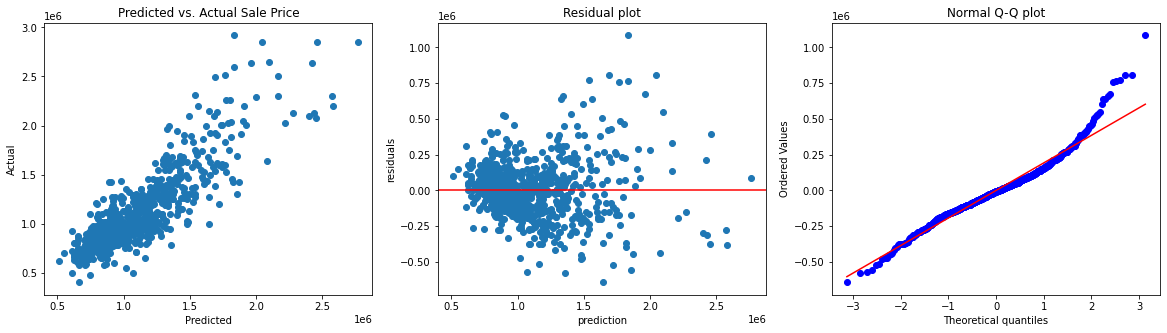

In [76]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, y4_cv, y4_pred)

#### On a Mean MAE basis, this is on par w/ Model 2

### Model 5 - "Lazy" ElasticNet Regression (all the variables in the model)

In [77]:
X5 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [78]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 0.01
Best L1 Ratio = 0.8


In [79]:
model_5 = ElasticNet(alpha=0.01, l1_ratio=0.8, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.791, 0.748, 0.712, 0.609, 0.689]
Mean CV R-squared: 0.71 +/- 0.061

Adjusted CV R-squareds: [0.787, 0.743, 0.706, 0.601, 0.683]
Mean Adjusted CV R-squared: 0.704 +/- 0.062

CV MAEs: [153336, 141855, 151799, 140637, 139735]
Mean CV MAE: 145472 +/- 5852


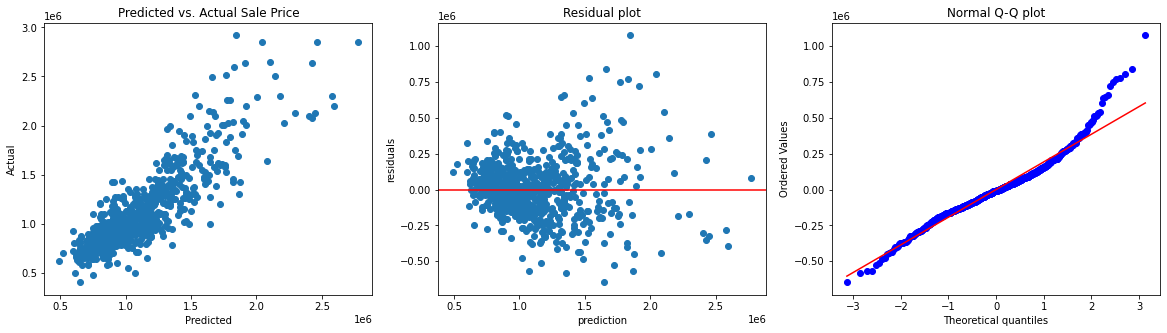

In [80]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, y5_cv, y5_pred)

#### This looks like the best yet (on a Mean CV MAE basis)

In [81]:
list(zip(X5_cv.columns, model_5.coef_))

[('beds', -36219.103941432746),
 ('baths', 17069.24374981462),
 ('hm_sqft', 194100.0751214087),
 ('lot_size', 113244.53821838746),
 ('yr_built', -29867.53323579435),
 ('garage', -7110.663684858245),
 ('one_story', 35985.381349020376),
 ('schools', -87365.15366347965),
 ('hoa', -555.7097281382759),
 ('beds_SQ', -12281.467923127519),
 ('baths_SQ', 78533.75963213068),
 ('hm_sqft_SQ', 26358.445393845035),
 ('lot_size_SQ', -35242.05515849344),
 ('schools_SQ', 167377.55608556766),
 ('yr_built_SQ', 17261.17068600986)]

In [82]:
var_magnitudes = sorted(list(zip(X5_cv.columns, model_5.coef_)), key=lambda x: x[1])

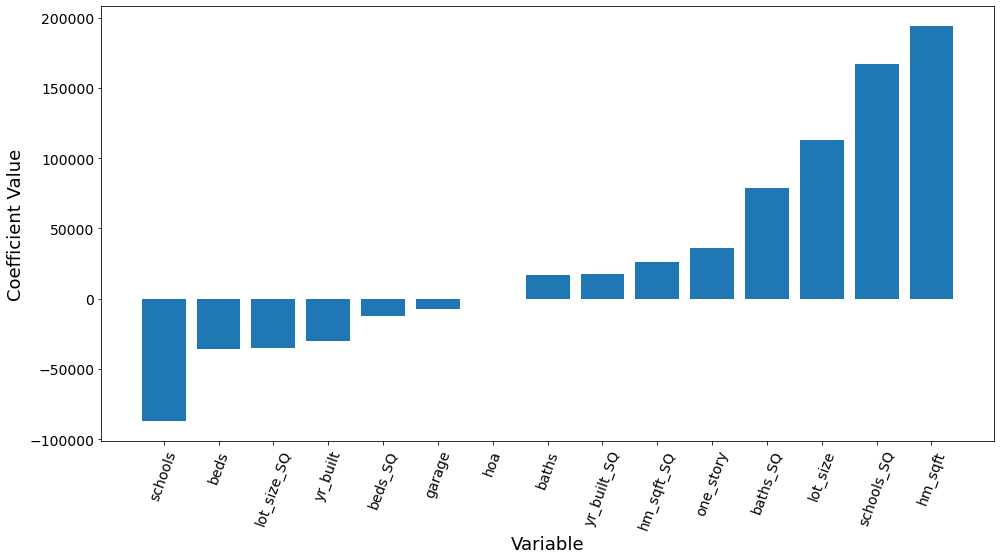

In [83]:
plt.figure(figsize=(16,8))
plt.bar(range(len(var_magnitudes)), [val[1] for val in var_magnitudes], align='center')
plt.xticks(range(len(var_magnitudes)), [val[0] for val in var_magnitudes])
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Variable', fontsize=18)
plt.ylabel('Coefficient Value', fontsize=18)
plt.show()

In [84]:
X5_cv_scaled[0]

array([ 0.46039717,  0.58051815,  0.33392887, -0.27152612,  1.45515338,
       -0.41093711, -2.19322114,  0.65198815, -0.11014995,  0.32065466,
        0.36528381,  0.12263283, -0.31495982,  0.61548229,  1.452118  ])

In [85]:
coeffs = [val[1] for val in list(zip(X5_cv.columns, model_5.coef_))]
pred = []
for n in range(len(X5_cv_scaled[0])):
    pred.append(X5_cv_scaled[0][n] * coeffs[n])
np.sum(pred) + model_5.intercept_

1111476.0176760484

### Model 6: Random Forest Regression

In [86]:
X6 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [87]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [88]:
rf_gridsearch.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [89]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [2000, 2100, 2200],
        'max_features': ['log2'],
        'max_depth': [5, 10, 15],
        'min_samples_split': [3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [True]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 15],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [2000, 2100, 2200]})

In [90]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 2100}

In [91]:
model_6 = RandomForestRegressor(
    n_estimators=2100,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=10,
    bootstrap=True
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.808, 0.758, 0.754, 0.643, 0.732]
Mean CV R-squared: 0.739 +/- 0.054

Adjusted CV R-squareds: [0.804, 0.753, 0.749, 0.636, 0.727]
Mean Adjusted CV R-squared: 0.734 +/- 0.055

CV MAEs: [140516, 134386, 134836, 133087, 121324]
Mean CV MAE: 132830 +/- 6292


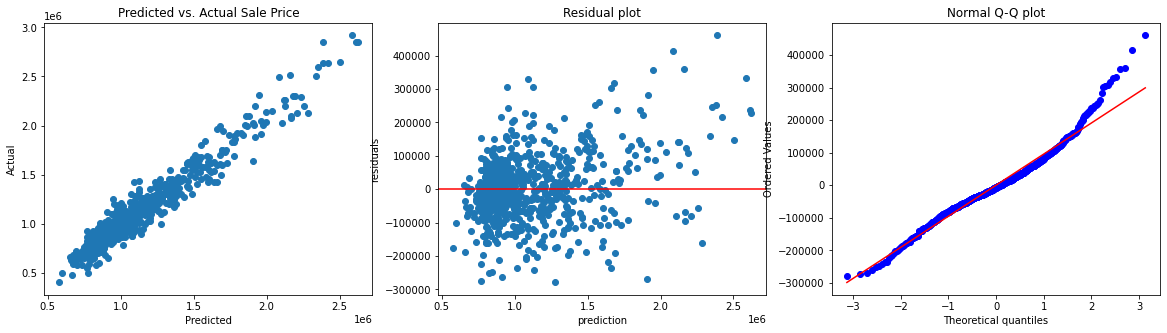

In [92]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, y6_cv, y6_pred)

In [93]:
feature_importances = sorted(list(zip(X6_cv.columns, model_6.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft_SQ', 0.19993621849544566),
 ('hm_sqft', 0.19959924912944288),
 ('lot_size', 0.10829236511558135),
 ('lot_size_SQ', 0.10749450733547032),
 ('baths', 0.08874167752393543),
 ('baths_SQ', 0.08818901258010718),
 ('schools_SQ', 0.04872998960146249),
 ('schools', 0.047168834334270535),
 ('yr_built', 0.02895917950225456),
 ('yr_built_SQ', 0.028771209176632544),
 ('beds_SQ', 0.022277315129549374),
 ('beds', 0.021366865441214054),
 ('one_story', 0.006448299495480732),
 ('garage', 0.002741225973938488),
 ('hoa', 0.0012840511652144975)]

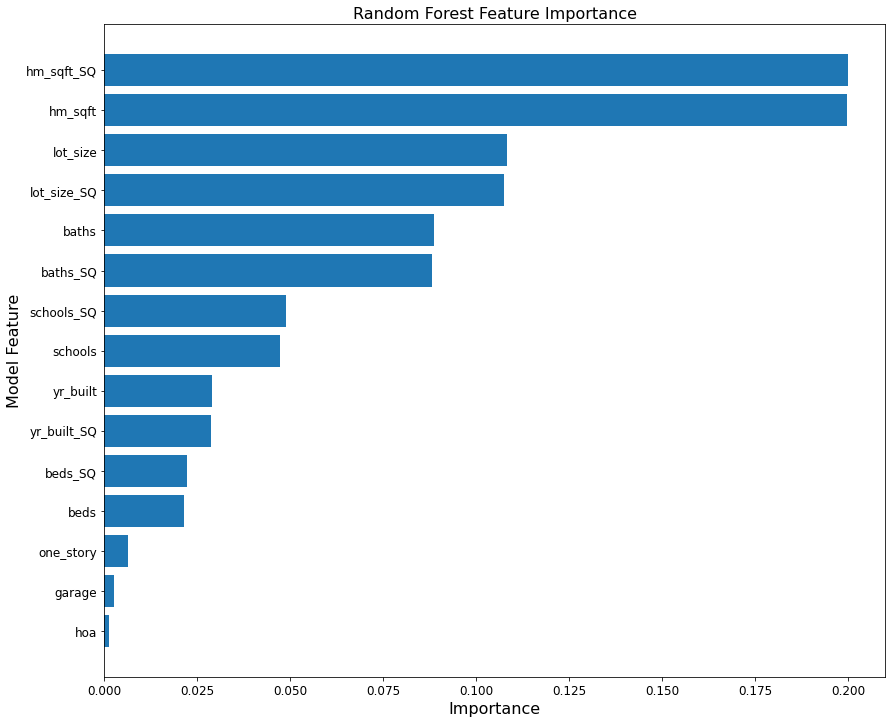

In [94]:
sorted_idx = model_6.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X6_cv.columns[sorted_idx], model_6.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

### Model 7 - XGBoost

In [95]:
X7 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X7_cv, X7_test, y7_cv, y7_test = train_test_split(X7, y, test_size=0.2, random_state=42)

In [97]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [98]:
warnings.filterwarnings(action='ignore', category=UserWarning)
xgb_gridsearch.best_params_

{'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.3}

In [99]:
# Updated/narrowed-down grid based on the results found by randomized search above
warnings.filterwarnings(action='ignore', category=UserWarning)
grid = {
        'learning_rate': [0.001, 0.005, 0.01],
        'max_depth': [4, 5, 6],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.2, 0.3, 0.4],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:squarederror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [100]:
warnings.filterwarnings(action='ignore', category=UserWarning)
grid_search.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 1200,
 'objective': 'reg:squarederror',
 'subsample': 0.6}

In [101]:
# Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_7 = xgboost.XGBRegressor(
        subsample=0.6,
        objective='reg:squarederror',
        n_estimators=1200,
        min_child_weight=2,
        max_depth=4,
        learning_rate=0.01,
        colsample_bytree=0.3
)

cv_rsquareds(X7_cv, y7_cv, model_7, 5)
cv_maes(X7_cv, y7_cv, model_7, 5)

CV R-squareds: [0.832, 0.798, 0.786, 0.692, 0.753]
Mean CV R-squared: 0.772 +/- 0.047

Adjusted CV R-squareds: [0.829, 0.794, 0.782, 0.686, 0.748]
Mean Adjusted CV R-squared: 0.768 +/- 0.048

CV MAEs: [134411, 120679, 126854, 122778, 119164]
Mean CV MAE: 124777 +/- 5467


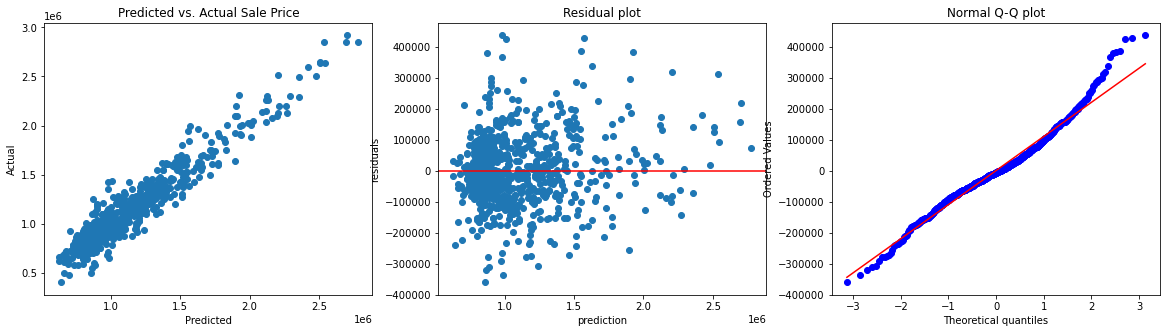

In [102]:
model_7.fit(X7_cv, y7_cv)

y7_pred = model_7.predict(X7_cv)

diagnostic_plots(X7_cv, y7_cv, y7_pred)

In [103]:
model_7.get_booster().get_score(importance_type="gain")

{'baths_SQ': 442760198552.84784,
 'lot_size_SQ': 339016591009.0771,
 'baths': 569392087506.419,
 'lot_size': 289290479910.2019,
 'schools': 184661101000.05402,
 'beds_SQ': 119822716116.89374,
 'yr_built': 78376061758.18562,
 'beds': 187612841468.28946,
 'hm_sqft': 375140762269.5919,
 'schools_SQ': 186641670655.10483,
 'yr_built_SQ': 80753316880.00438,
 'hm_sqft_SQ': 408646447235.7227,
 'one_story': 89983663177.9119,
 'hoa': 42335427905.674416,
 'garage': 60248159147.42342}

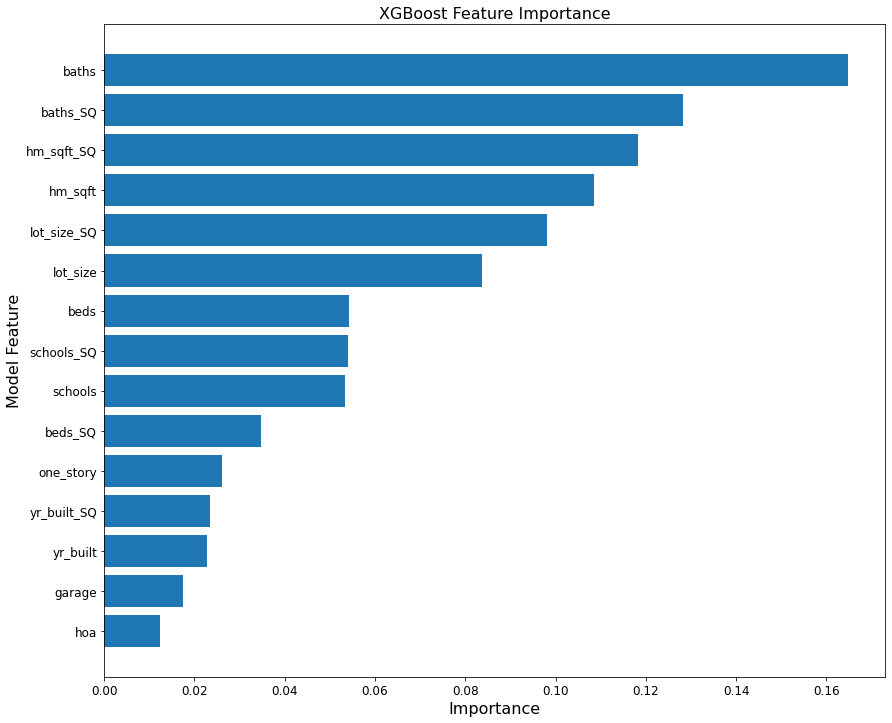

In [104]:
sorted_idx = model_7.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X7_cv.columns[sorted_idx], model_7.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [105]:
feature_importances = sorted(list(zip(X7_cv.columns, model_7.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('baths', 0.16481753),
 ('baths_SQ', 0.12816237),
 ('hm_sqft_SQ', 0.11828773),
 ('hm_sqft', 0.1085891),
 ('lot_size_SQ', 0.098132506),
 ('lot_size', 0.08373868),
 ('beds', 0.05430684),
 ('schools_SQ', 0.054025725),
 ('schools', 0.05345242),
 ('beds_SQ', 0.034684155),
 ('one_story', 0.026046876),
 ('yr_built_SQ', 0.023375038),
 ('yr_built', 0.022686912),
 ('garage', 0.017439568),
 ('hoa', 0.012254509)]